In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom
import skimage

In [2]:
#load NIH data
all_xray_df = pd.read_csv('D:/data science competitions datasets/NIH Chest X-rays/Data_Entry_2017.csv')
all_xray_df.head(10)
## Load 'sample_labels.csv' data for pixel level assessments
# sample_df = pd.read_csv('sample_labels.csv')
# sample_df.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


In [3]:
df = all_xray_df.copy()
all_findings = np.unique(list(chain(*df['Finding Labels'].map(lambda x:x.split('|')).tolist())))
all_findings
for label in all_findings:
    df[label]=df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

Patient Gender
F    48780
M    63340
Name: Patient ID, dtype: int64

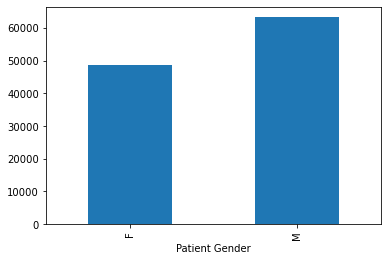

In [4]:
# Gender
gender_count = df.groupby(['Patient Gender'])['Patient ID'].count()
gender_count.plot(kind='bar')
gender_count

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

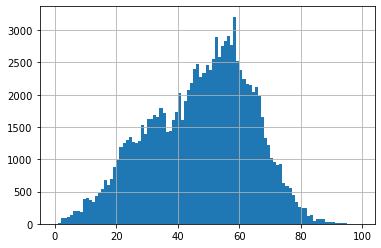

In [5]:
# Age
df['Patient Age'].hist(bins=np.arange(0,100,1))
df['Patient Age'].describe()

View Position
AP    44810
PA    67310
Name: Patient ID, dtype: int64

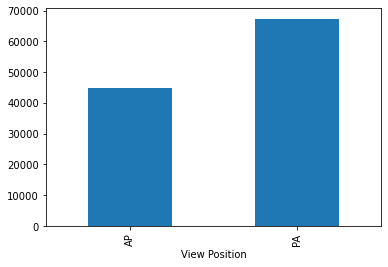

In [6]:
# View Patient Position
vp_count = df.groupby(['View Position'])['Patient ID'].count()
vp_count.plot(kind='bar')
vp_count

In [7]:
# number of findings
print('Number of finding labels in the dataset:', len(all_findings))
all_findings

Number of finding labels in the dataset: 15


array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

,count,mean,std,min,25%,50%,75%,max
Pneumonia,,,,,,,,
0,110689.0,46.926985,16.791759,1.0,35.0,49.0,59.0,414.0
1,1431.0,44.927324,20.129866,2.0,31.0,46.0,59.0,412.0


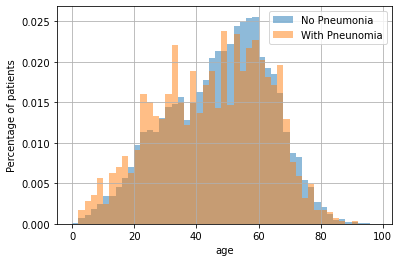

In [8]:
# Age distribution with and without pneunomia
df.groupby(['Pneumonia'])['Patient Age'].hist(bins=np.arange(0,100,2), density=True, alpha=0.5)
plt.legend(['No Pneumonia', 'With Pneunomia'])
plt.ylabel('Percentage of patients')
plt.xlabel('age')
df.groupby(['Pneumonia'])['Patient Age'].describe()

In [9]:
df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

[Text(0, 0.5, 'Frequency')]

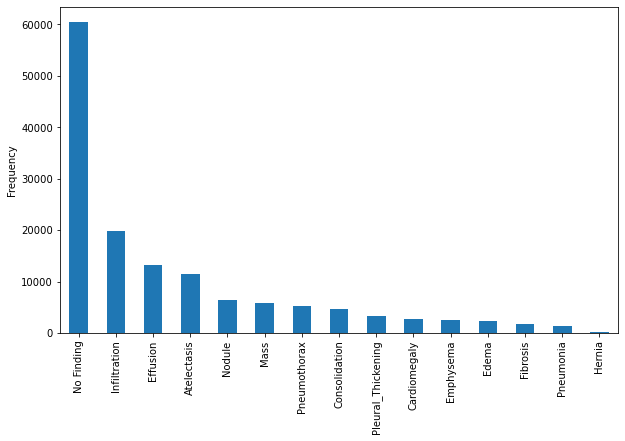

In [10]:
# Labels frequency Histogram
plt.figure(figsize=(10,6))
labels_hist = df[all_findings].sum().sort_values(ascending=False).plot(kind='bar')
labels_hist.set(ylabel = 'Frequency')

## Pneumonia EDA

In [11]:
positive_pneumonia = df[df.Pneumonia==1]['Patient ID'].value_counts().sum()
negative_pneumonia = df[df.Pneumonia==0]['Patient ID'].value_counts().sum()

print(f'Pneuomonia cases: {positive_pneumonia}/{negative_pneumonia}')

Pneuomonia cases: 1431/110689


M    838
F    593
Name: Patient Gender, dtype: int64

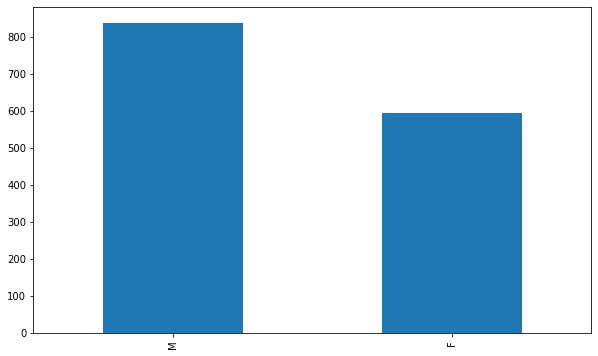

In [12]:
# frquency of pneumonia cases based on gender
pneumonia_gender=df[df.Pneumonia==1]['Patient Gender'].value_counts()
plt.figure(figsize=(10,6))
pneumonia_gender.plot(kind='bar')
pneumonia_gender

[Text(0.5, 1.0, 'Age distribution for patients with Pneumonia')]

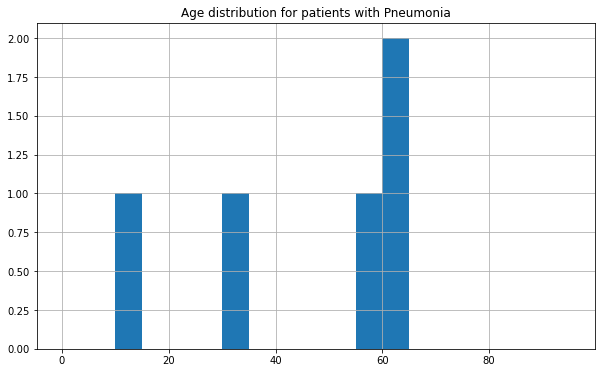

In [13]:
# Info about Pneumonia cases based on age
df.groupby(['Pneumonia'])['Patient Age'].describe()
plt.figure(figsize=(10,6))
dist = df[df.Pneumonia == 1]['Patient ID'].hist(bins=np.arange(0,100,5))
dist.set(title = 'Age distribution for patients with Pneumonia')

<AxesSubplot:>

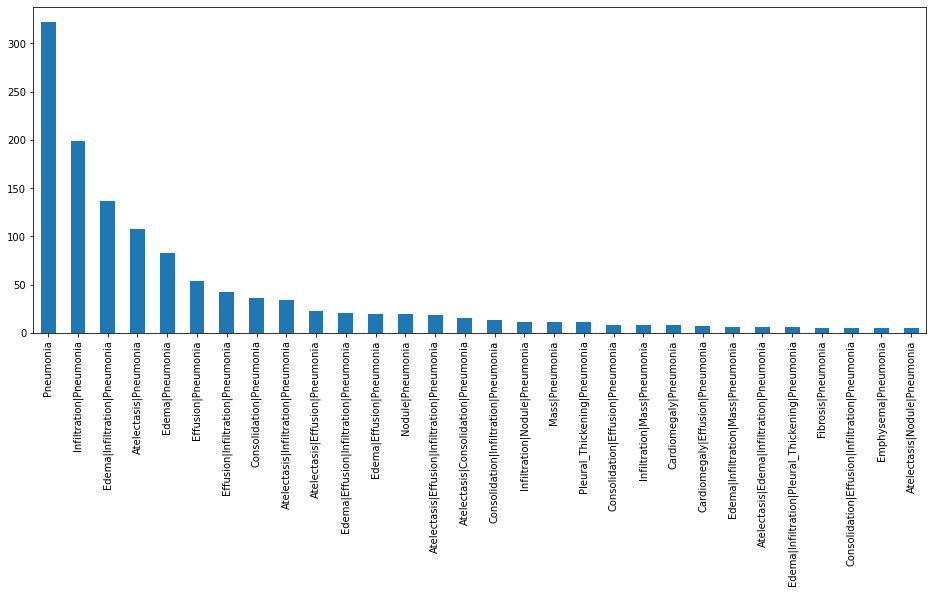

In [14]:
# Distribution of top 30 diseases that are comorbid with Pneumonia
plt.figure(figsize=(16,6))
df[df.Pneumonia==1]['Finding Labels'].value_counts()[:30].plot(kind='bar')

In [15]:
# Reading all DICOMs files
mydicoms = glob("*.dcm")
mydicoms

['test1.dcm', 'test2.dcm', 'test3.dcm', 'test4.dcm', 'test5.dcm', 'test6.dcm']

In [16]:
# Create df from all files
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)

In [17]:
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [18]:
mydata

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,2,81,M,DX,No Finding,1024,1024
1,1,58,M,DX,Cardiomegaly,1024,1024
2,61,77,M,DX,Effusion,1024,1024
3,2,81,M,DX,No Finding,1024,1024
4,2,81,M,CT,No Finding,1024,1024
5,2,81,M,DX,No Finding,1024,1024


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.110503645592756492463169821050252582267888
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'No Finding'
(0010, 0020) Patien

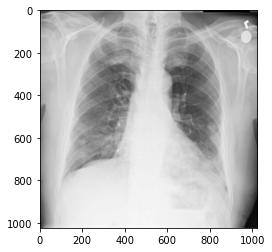

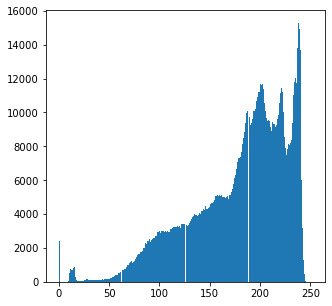

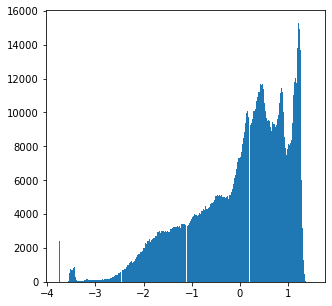

In [19]:
# Patient with "No Findings"
# Using the imshow to show the image based on the pixel_array
dcm_1 = pydicom.dcmread('test1.dcm')
print(dcm_1)
dcm_1_array = dcm_1.pixel_array

#Plotting the images
plt.imshow(dcm_1_array,cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.hist(dcm_1_array.ravel(), bins=256)
plt.show()


# Making the normalization
dmc_1_mean = np.mean(dcm_1_array)
dcm_1_std= np.std(dcm_1_array)
new_dcm_1 = dcm_1_array.copy()
dcm_1_standard = (new_dcm_1 - dmc_1_mean)/dcm_1_std

plt.figure(figsize=(5,5))
plt.hist(dcm_1_standard.ravel(), bins=256)
plt.show()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.11129.5.5.179222148351666120521423991179194552820263
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.179222148351666120521423991179194552820263
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'Effusion'
(0010, 0020) Patient 

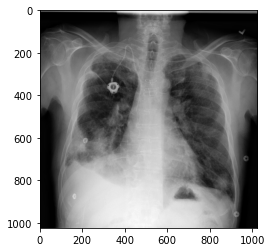

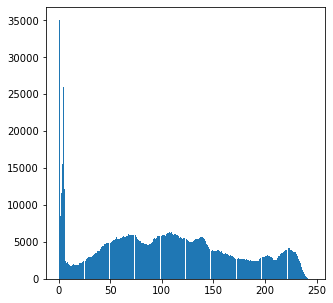

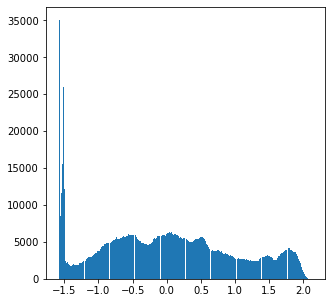

In [20]:
# Patient with "Effusion"
# Using the imshow to show the image based on the pixel_array
dcm_4 = pydicom.dcmread('test3.dcm')
print(dcm_4)
dcm_4_array = dcm_4.pixel_array

#Plotting the images
plt.imshow(dcm_4_array,cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.hist(dcm_4_array.ravel(), bins=256)
plt.show()


# Making the normalization
dmc_4_mean = np.mean(dcm_4_array)
dcm_4_std= np.std(dcm_4_array)
new_dcm_4 = dcm_4_array.copy()
dcm_4_standard = (new_dcm_4 - dmc_4_mean)/dcm_4_std

plt.figure(figsize=(5,5))
plt.hist(dcm_4_standard.ravel(), bins=256)
plt.show()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.11129.5.5.153751009835107614666834563294684339746480
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 1.2.0'
-------------------------------------------------
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.11129.5.5.153751009835107614666834563294684339746480
(0008, 0060) Modality                            CS: 'DX'
(0008, 1030) Study Description                   LO: 'Cardiomegaly'
(0010, 0020) Pati

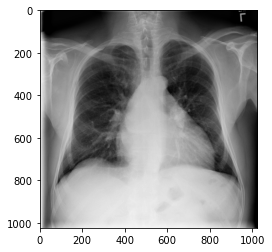

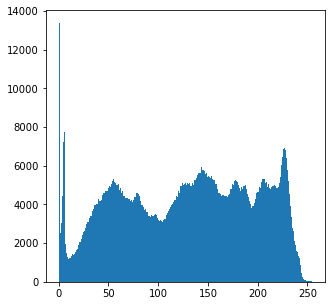

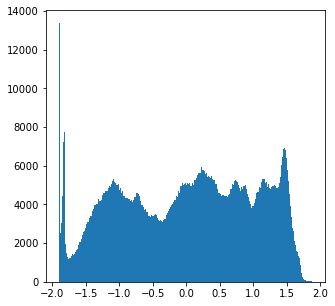

In [21]:
# Patient with "Cardiomegaly"
# Using the imshow to show the image based on the pixel_array
dcm_2 = pydicom.dcmread('test2.dcm')
print(dcm_2)
dcm_2_array = dcm_2.pixel_array

#Plotting the images
plt.imshow(dcm_2_array,cmap='gray')
plt.show()

plt.figure(figsize=(5,5))
plt.hist(dcm_2_array.ravel(), bins=256)
plt.show()


# Making the normalization
dmc_2_mean = np.mean(dcm_2_array)
dcm_2_std= np.std(dcm_2_array)
new_dcm_2 = dcm_2_array.copy()
dcm_2_standard = (new_dcm_2 - dmc_2_mean)/dcm_2_std

plt.figure(figsize=(5,5))
plt.hist(dcm_2_standard.ravel(), bins=256)
plt.show()

In [22]:
pneumonia_labels = [f for f in df["Finding Labels"] if "Pneumonia" in f]
pneumonia_labels = set(pneumonia_labels)
pneumonia_labels

{'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Pneumonia',
 'Atelectasis|Cardiomegaly|Edema|Effusion|Infiltration|Nodule|Pneumonia',
 'Atelectasis|Cardiomegaly|Effusion|Infiltration|Pneumonia',
 'Atelectasis|Cardiomegaly|Effusion|Pneumonia',
 'Atelectasis|Cardiomegaly|Pneumonia',
 'Atelectasis|Consolidation|Edema|Effusion|Infiltration|Mass|Nodule|Pleural_Thickening|Pneumonia',
 'Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia',
 'Atelectasis|Consolidation|Edema|Effusion|Pneumonia',
 'Atelectasis|Consolidation|Edema|Infiltration|Pneumonia',
 'Atelectasis|Consolidation|Edema|Pneumonia',
 'Atelectasis|Consolidation|Edema|Pneumonia|Pneumothorax',
 'Atelectasis|Consolidation|Effusion|Infiltration|Pneumonia',
 'Atelectasis|Consolidation|Effusion|Pneumonia',
 'Atelectasis|Consolidation|Infiltration|Mass|Pneumonia',
 'Atelectasis|Consolidation|Infiltration|Pneumonia',
 'Atelectasis|Consolidation|Mass|Pneumonia',
 'Atelectasis|Consolidation|Nodule|Pneumonia',
 'A

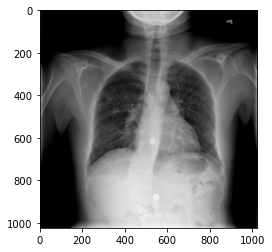

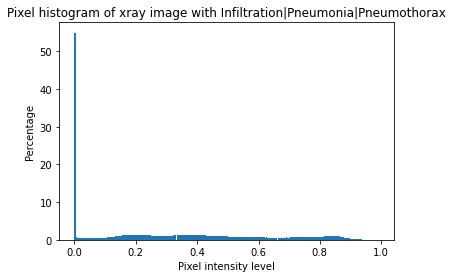

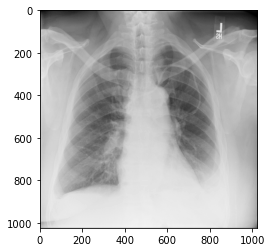

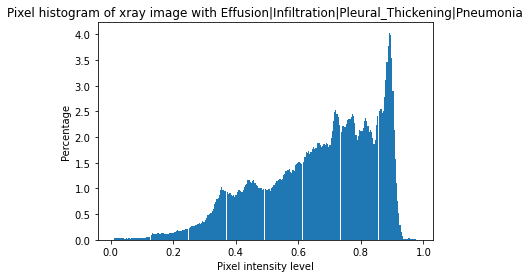

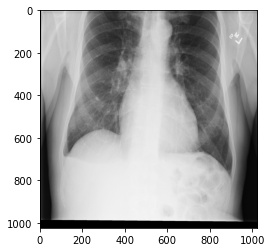

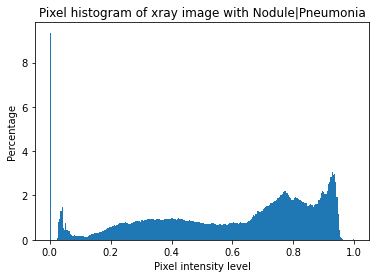

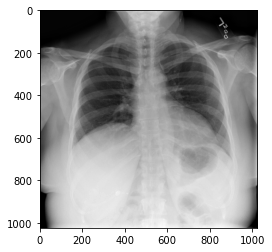

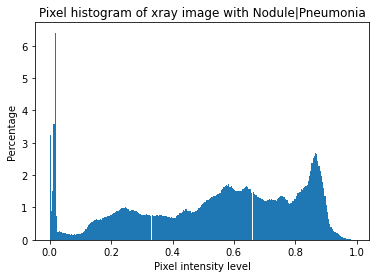

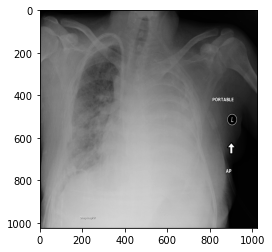

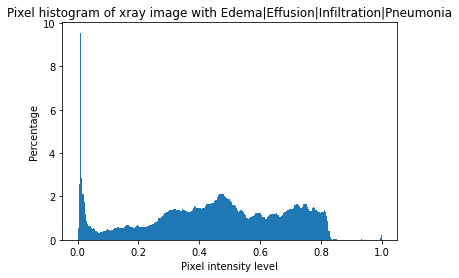

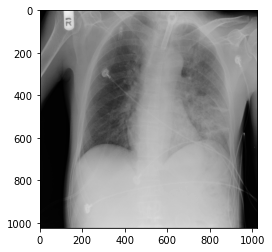

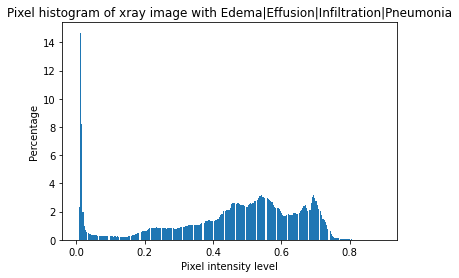

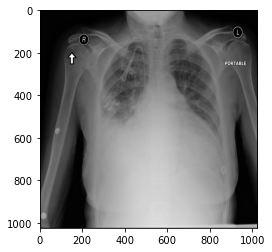

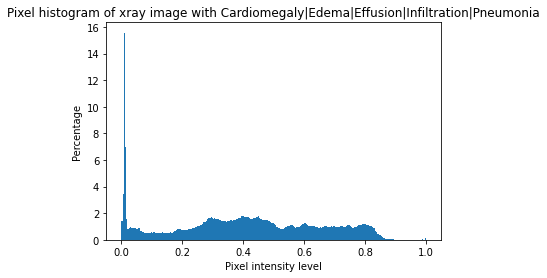

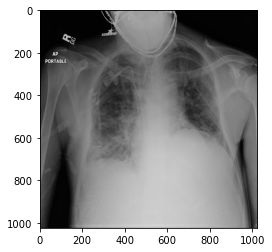

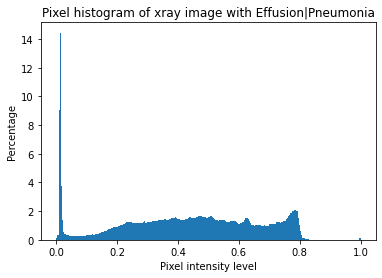

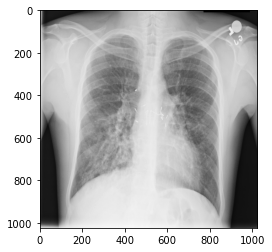

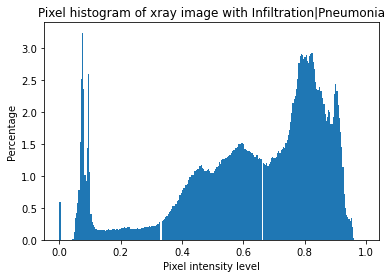

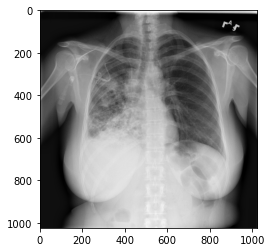

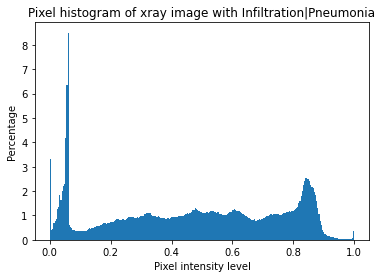

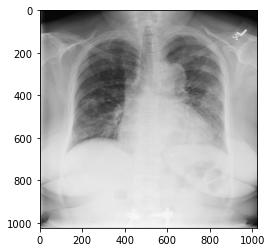

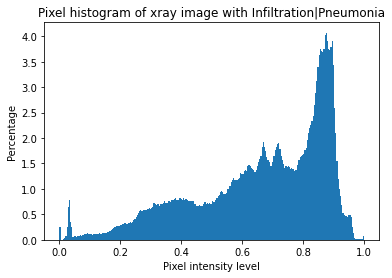

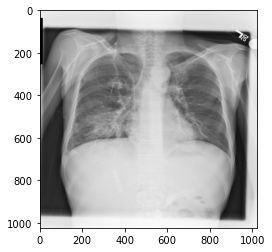

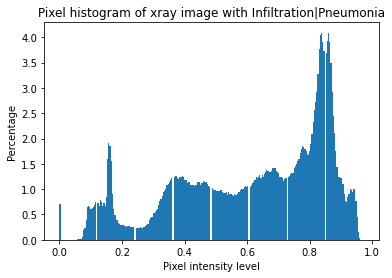

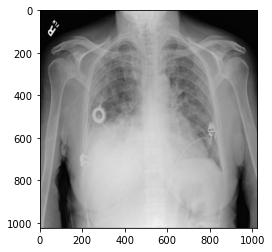

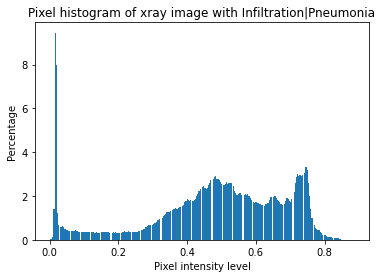

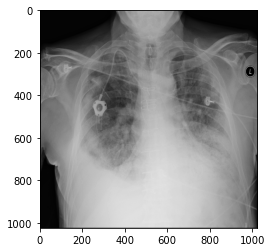

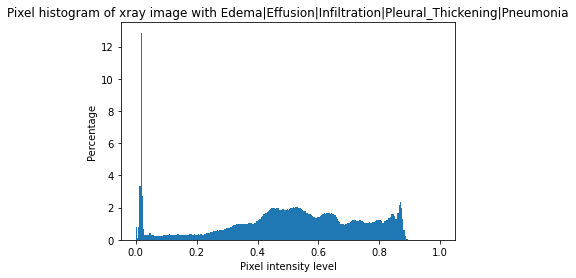

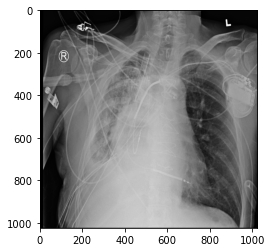

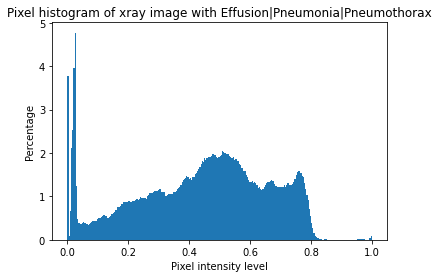

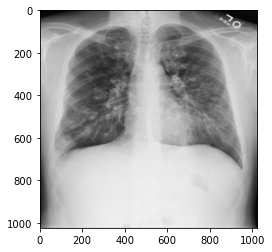

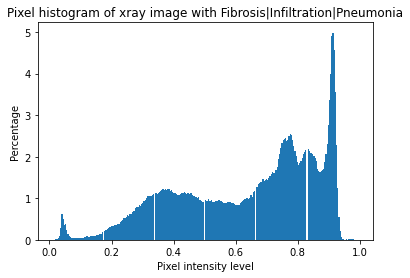

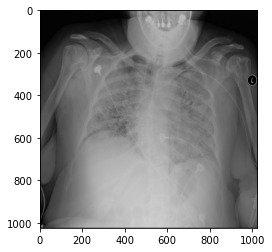

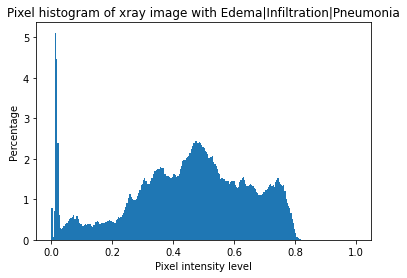

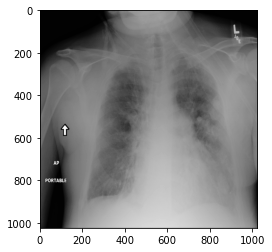

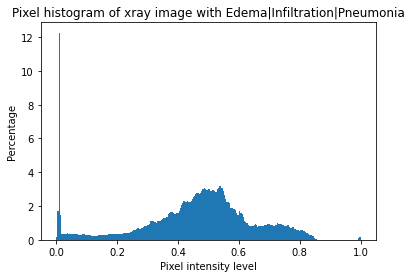

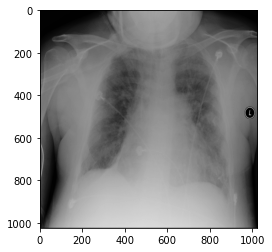

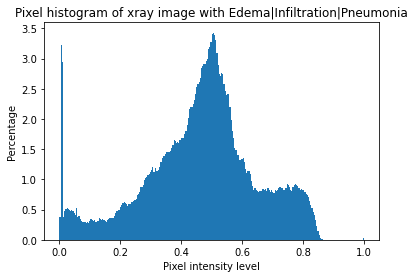

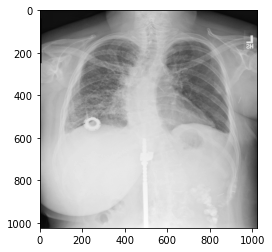

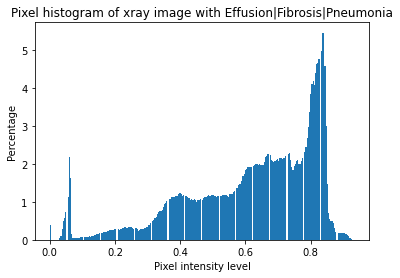

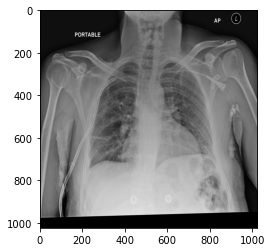

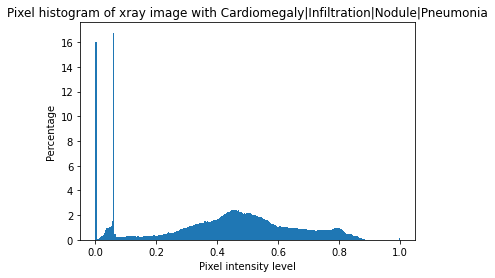

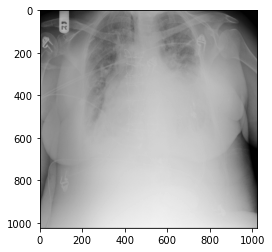

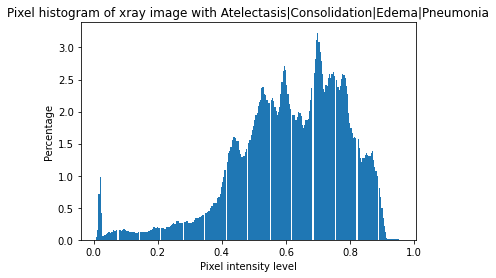

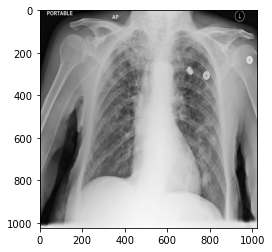

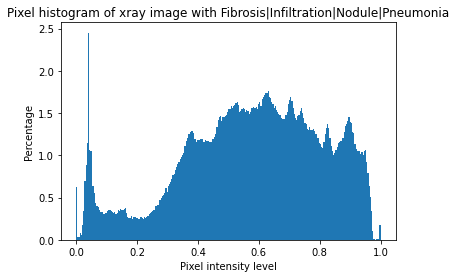

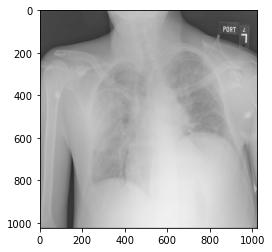

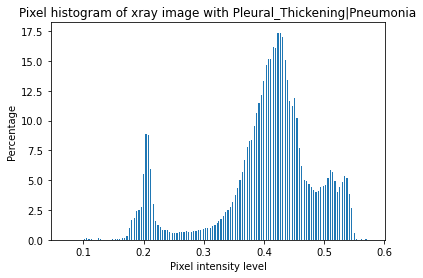

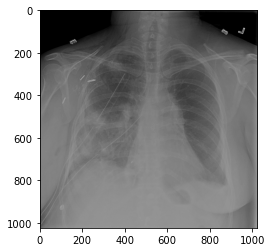

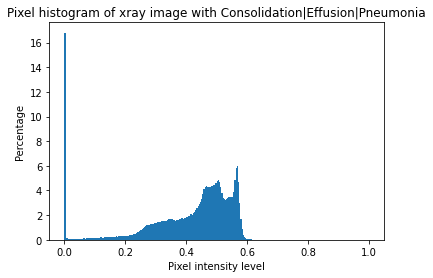

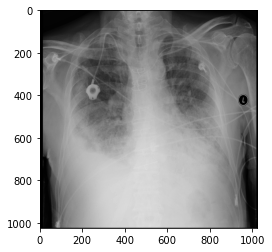

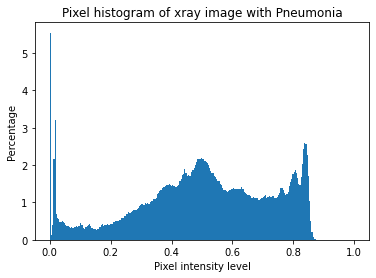

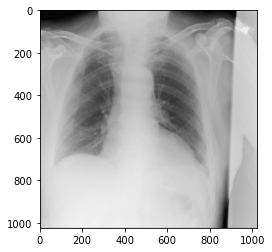

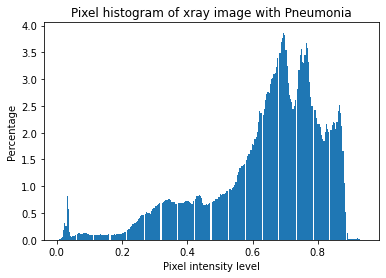

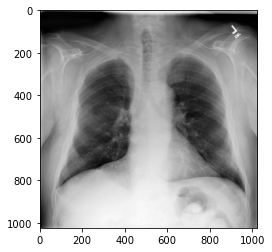

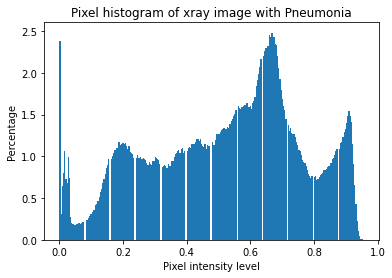

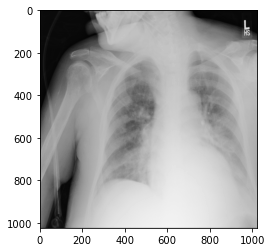

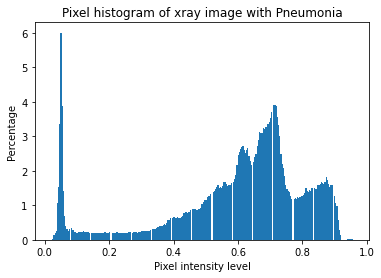

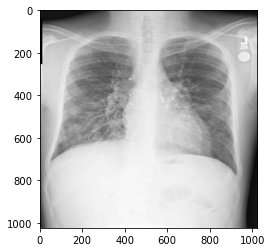

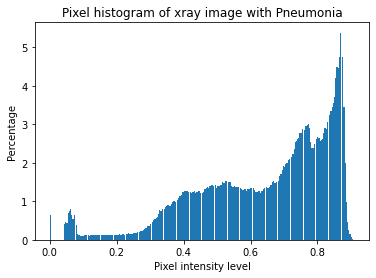

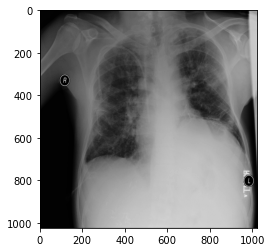

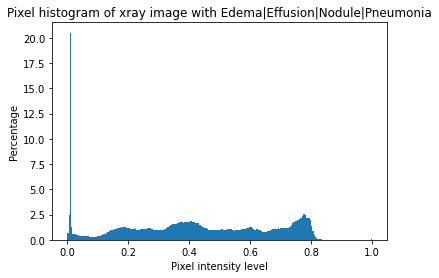

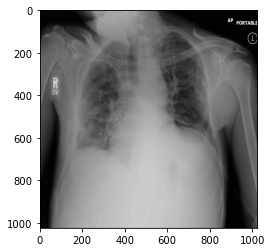

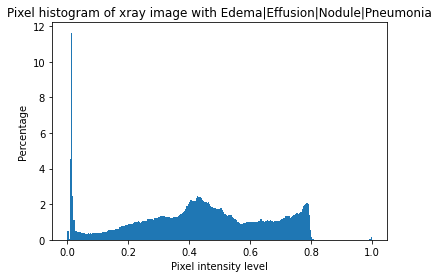

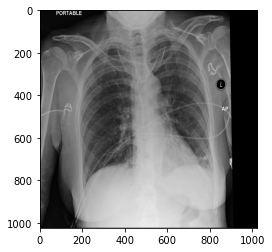

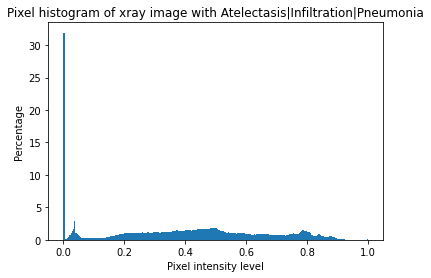

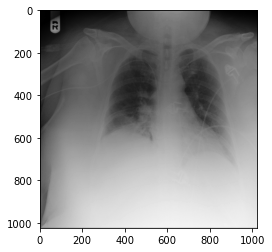

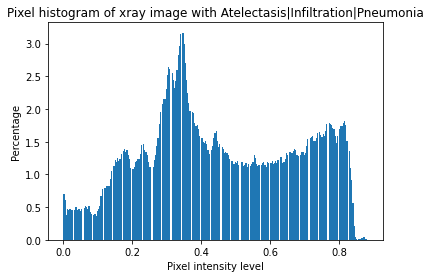

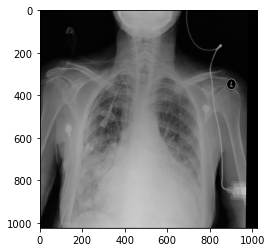

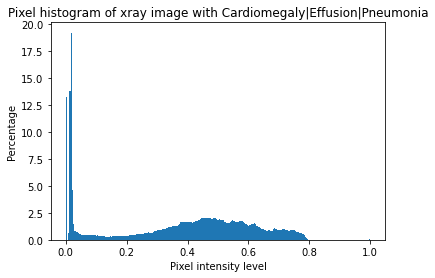

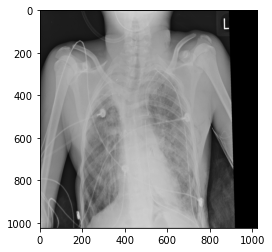

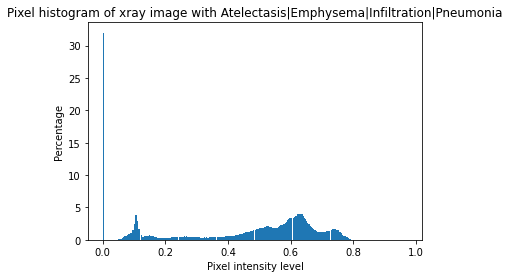

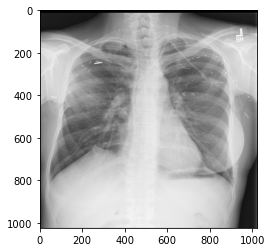

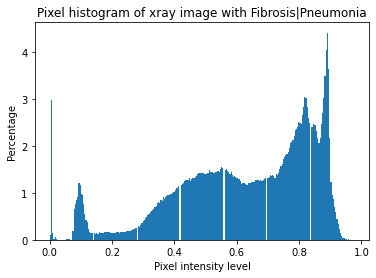

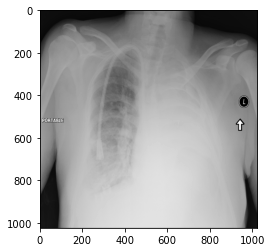

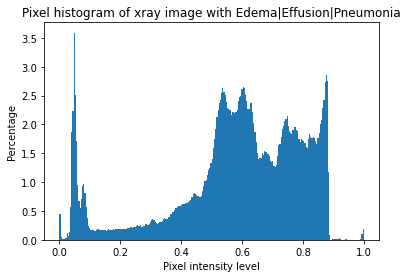

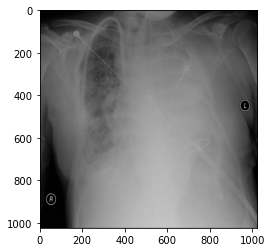

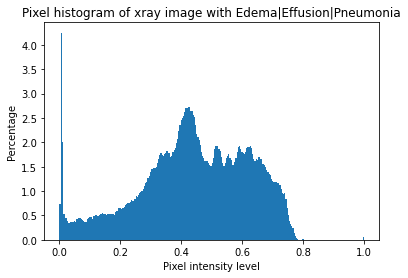

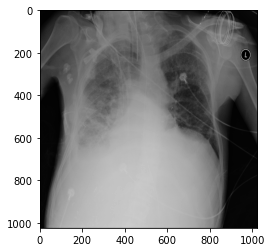

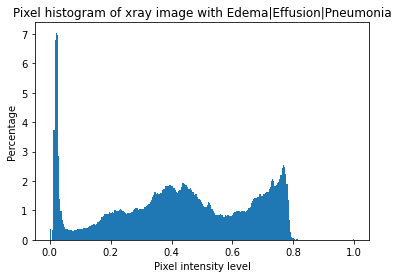

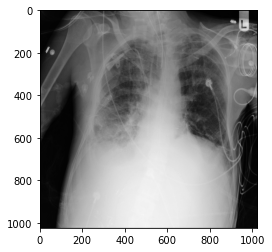

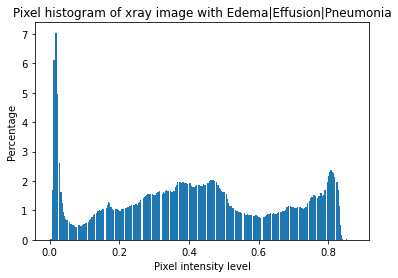

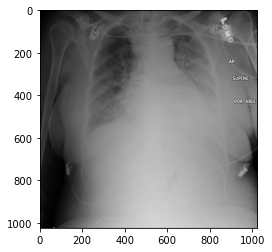

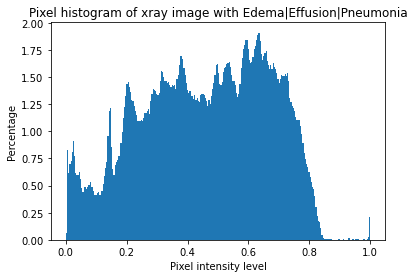

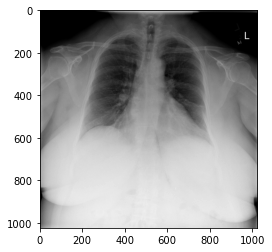

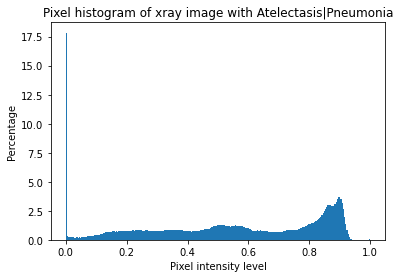

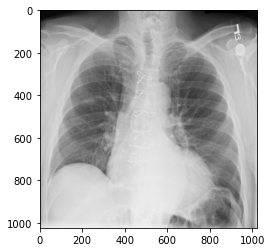

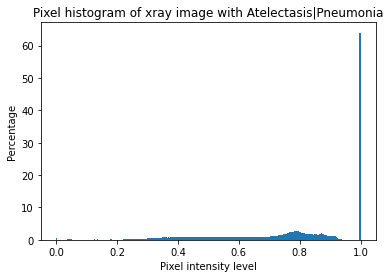

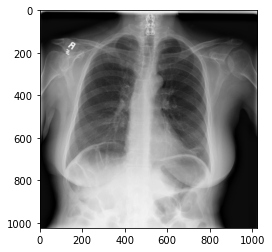

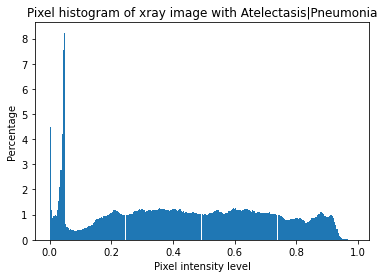

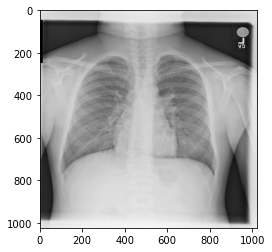

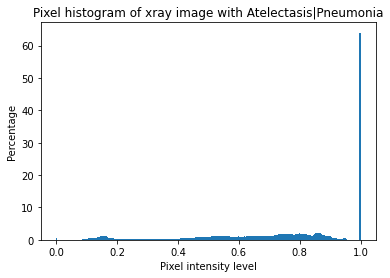

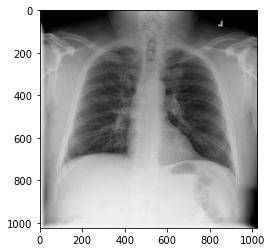

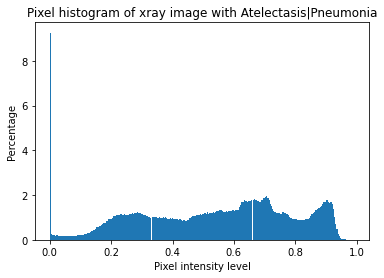

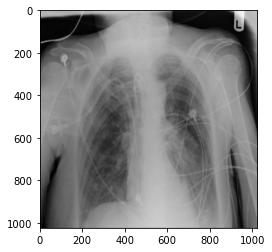

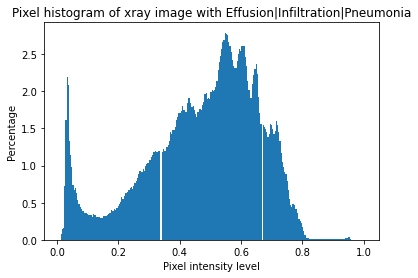

In [23]:
for finding in pneumonia_labels:
    for i, row in df[df['Finding Labels']==finding].head(5).iterrows():
        path = os.path.join("D:/data science competitions datasets/NIH Chest X-rays/images_001/images", row['Image Index'])
        if not os.path.exists(path): continue
        img = plt.imread(path)
        plt.imshow(img, cmap='gray')
        plt.show()
        
        plt.hist(img.ravel(), bins=256, density=True)
        plt.ylabel('Percentage')
        plt.xlabel('Pixel intensity level')    
        plt.title('Pixel histogram of xray image with {}'.format(finding))
        plt.show()

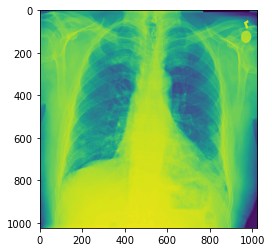

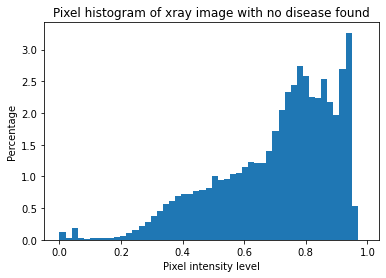

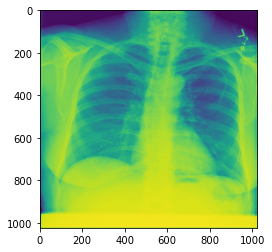

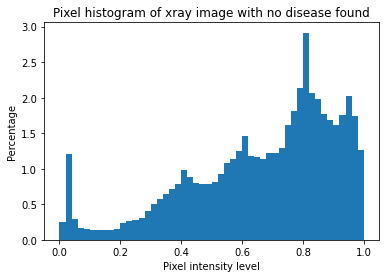

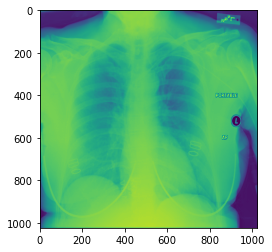

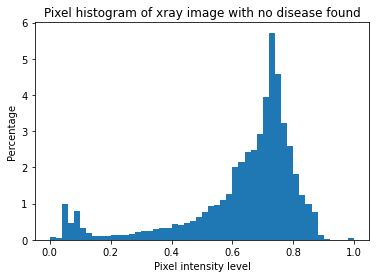

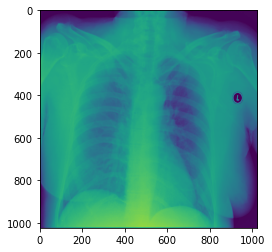

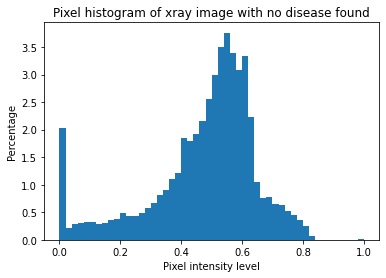

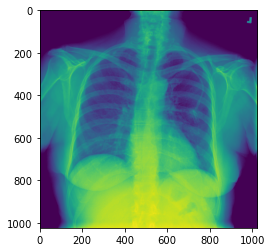

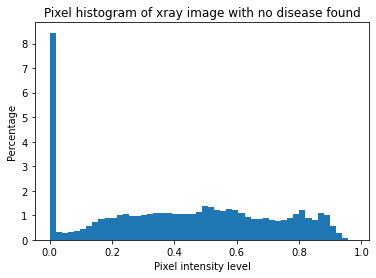

In [24]:
# plot images with no findings
for i, row in df[df['Finding Labels']=="No Finding"].head(5).iterrows():
    path = os.path.join("D:/data science competitions datasets/NIH Chest X-rays/images_001/images", row['Image Index'])
    if not os.path.exists(path): continue
    img = plt.imread(path)
    plt.imshow(img)
    plt.show()
    _ = plt.hist(img.reshape(-1), bins=50, density=True)
    plt.ylabel('Percentage')
    plt.xlabel('Pixel intensity level')    
    plt.title('Pixel histogram of xray image with no disease found')
    plt.show()

## Discussions

From the figures above, it looks like:

- The images with no findings show a tendency toward bright intensity.
- Image intensities with Pneumonia peak at around the middle.
- Noise needs to be removed.
- Data augmentation is required since the dataset contains few pationts with Pneumonia compared to its size.
- The intensity distribution curve of Pneumonia looks like that of Infiltration. Because Pneumonia has a similarity with infiltration then whenever infiltration is presented then it will be hard for your model to distinguish between them.
- There are outliers such as the age 414 which most likely is because of a type error.